<a href="https://colab.research.google.com/github/MrGrayCode/Clustering-CNN-Features/blob/master/Clustering_CNN_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import Libraries

In [0]:
import cv2
import pandas as pd
import numpy as np
import imutils
import torch
import torchvision
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from PIL import Image, ImageOps
from google.colab.patches import cv2_imshow

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Load Video

In [0]:
videoPath = "/content/drive/My Drive/MaskRCNNData/sample_video.mp4"

In [0]:
cap = cv2.VideoCapture(videoPath)
fps = cap.get(cv2.CAP_PROP_FPS)
numFrames = 0
frames = []
X = []
while True:
    numFrames += 1
    ret, frame = cap.read()
    if ret:
        if not numFrames%fps:
            frame = imutils.resize(frame, width=200)
            frames.append(frame)
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            X.append(cv2.calcHist([gray],[0],None,[256],[0,256]))
    else:
        break

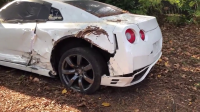

In [6]:
cv2_imshow(frames[0])

In [7]:
print("Total frames: %d"%numFrames)
print("FPS: %d"%fps)

Total frames: 1030
FPS: 30


# Clustering based on CNN Features

## Global

In [0]:
class PadSquare:
    def __call__(self, img):
        width, height = img.size
        maxDimension = max(width, height)
        deltaWidth = maxDimension - width
        deltaHeight = maxDimension - height
        padding = (deltaWidth//2, deltaHeight//2, deltaWidth -
                   (deltaWidth//2), deltaHeight - (deltaHeight//2))
        newImg = ImageOps.expand(img, padding)
        return newImg

In [0]:
transform = transforms.Compose([
            PadSquare(),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

## Resnet

### Define model and load saved dict

In [0]:
%%capture
model = models.resnet18()
numFC = model.fc.in_features
model.fc = nn.Linear(numFC, 3)
model.load_state_dict(torch.load("/content/drive/My Drive/Saved Models/BestModels/Side/resnet18-7661.pth"))

In [0]:
nmodel = nn.Sequential(*list(model.children())[:-1])

In [0]:
pilFrames = [transform(Image.fromarray(frame)).unsqueeze(0) for frame in frames]

In [0]:
def getOutput(model,frame):
    output = model(frame)
    output = torch.reshape(output,(512,))
    output = output.detach().numpy()
    return output

In [0]:
outputs = np.array([getOutput(nmodel,frame) for frame in pilFrames])

In [15]:
outputs[0].shape

(512,)

### Agglomerative Clustering

In [0]:
numClusters = 5

In [0]:
tsneRes = TSNE().fit_transform(outputs)

In [0]:
clustering = AgglomerativeClustering(n_clusters=numClusters).fit(outputs)
y = clustering.labels_

In [29]:
tsneRes.shape

(34, 2)

In [0]:
tsneDf = pd.DataFrame(tsneRes,columns=['tsne-1','tsne-2'])
tsneDf['y'] = y

In [0]:
x = [res[0] for res in tsneRes]
y = [res[1] for res in tsneRes]

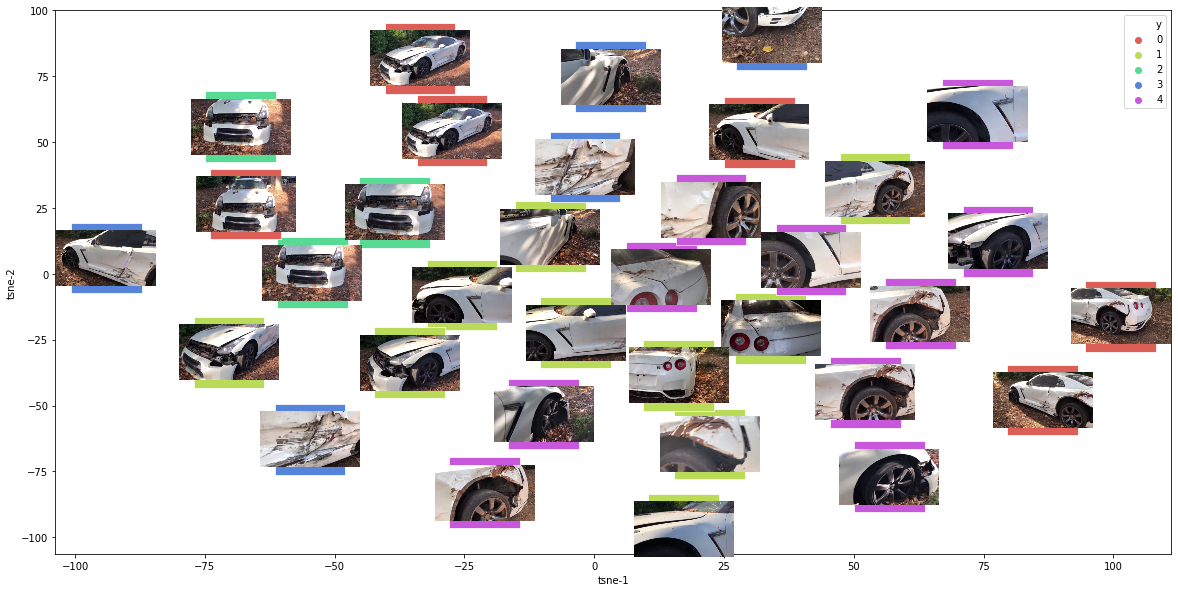

In [36]:
fig,ax = plt.subplots(figsize=(20, 10))
for x0, y0, frame in zip(x, y,frames):
    ab = AnnotationBbox(OffsetImage(frame[:,:,::-1], zoom=0.5), (x0, y0), frameon=False)
    ax.add_artist(ab)
sns.scatterplot(
    x='tsne-1',
    y='tsne-2',
    hue = 'y',
    palette=sns.color_palette("hls", numClusters),
    data=tsneDf,
    s=5000,
    marker = 's'
)